# Portfolio Constructions Using Centralities


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from PMFG_mod import PMFG

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#from scipy.stats import spearmanr


## Importing Data

In [2]:
# S&P constituents daily return data
use_IVV = False

if use_IVV:
    raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')

    log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
    # drop first row of raw prices so it has the same dimensions as the log-returns DF
    raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
    stock_names = log_returns_df.columns

    df_shape = (raw_asset_prices_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

    print(log_returns_df.head())
else:
    log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
    stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
    df_shape = (log_returns_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")
    
ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


In [4]:
# S&P500 daily returns
SnP_returns = pd.read_csv('SnP_returns.csv', index_col='DATE', parse_dates=True).squeeze()
SnP_returns

DATE
2016-01-04   -0.015304
2016-01-05    0.002012
2016-01-06   -0.013115
2016-01-07   -0.023700
2016-01-08   -0.010838
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: sprtrn, Length: 1006, dtype: float64

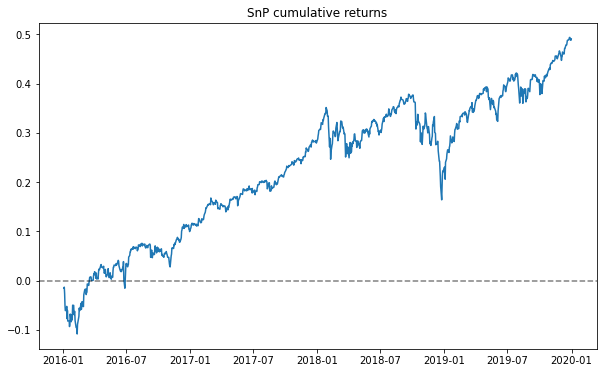

In [5]:
plt.figure(figsize=(10,6))
plt.title('SnP cumulative returns')
plt.plot(SnP_returns.cumsum())
plt.axhline(0, linestyle='--', color='k', alpha=.5)
plt.show()

In [6]:
# XY centrality ranking; computed in the previous workbook
XY_rankings = pd.read_csv("XY_rankings.csv", index_col='Date', parse_dates=True)
print(XY_rankings.info())

# quarterly rebalanced XY ranking
XY_rankings.iloc[::63]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2017-01-03 to 2019-12-30
Columns: 485 entries, A to ZTS
dtypes: float64(485)
memory usage: 2.8 MB
None


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,438.0,442.0,60.0,241.5,119.0,226.0,65.5,427.0,270.5,437.0,...,315.0,273.0,30.0,188.0,432.0,306.0,63.5,203.0,307.5,243.0
2017-04-04,440.0,381.5,193.0,206.5,214.0,210.0,184.0,427.0,374.0,439.0,...,319.0,329.0,71.0,216.5,403.5,272.0,140.0,206.5,327.0,274.0
2017-07-05,400.0,408.0,76.0,206.0,205.0,216.0,154.0,376.0,320.0,434.0,...,390.0,256.0,73.0,122.5,425.0,257.5,105.5,210.0,203.0,163.0
2017-10-03,436.0,408.0,50.5,283.0,201.5,242.0,242.0,424.0,247.0,452.0,...,390.0,292.0,16.0,104.5,304.5,266.0,165.5,236.0,186.0,271.0
2018-01-03,433.0,395.0,112.0,370.0,64.0,250.0,210.0,374.0,268.5,426.0,...,319.5,372.0,43.5,97.5,323.0,319.5,144.5,206.5,216.0,331.5
2018-04-05,445.0,405.0,84.0,369.5,128.0,236.5,54.0,396.0,394.5,379.0,...,322.0,339.5,150.0,91.5,344.0,137.0,65.0,185.0,135.0,308.5
2018-07-05,406.0,446.0,79.0,333.0,34.0,269.0,151.5,404.0,412.5,396.0,...,298.0,378.0,187.0,110.0,382.0,285.0,93.0,154.0,211.5,371.0
2018-10-03,399.0,437.0,103.0,376.0,23.0,287.0,171.0,430.0,414.0,358.5,...,313.0,386.0,145.0,25.0,397.0,126.0,72.0,221.0,236.0,381.5
2019-01-04,401.0,440.0,152.0,352.0,170.0,194.0,229.0,429.0,414.0,445.0,...,280.0,370.0,112.0,61.0,364.0,318.0,74.0,231.5,299.0,319.0


## "Investing in peripherals"
Pozzi proposed that investing in peripherals is better than investing in centrals in terms of information ratio; that peripherals achieve an IR comparable to that of market; and that centrals consistently underperform any other options. Let's see if that's true.

In [7]:
# wrap the whole correlation construction into one function?
def shrinkage_estimator(corr, shrinkage_coef):
    shrinkage_target=np.eye(corr.shape[1])
    return corr*(1-shrinkage_coef) + shrinkage_target*shrinkage_coef

def markowitz_min_var(Cinv):
    u = np.ones(len(Cinv))
    minvar = u@Cinv@u
    return Cinv@u/minvar

class Backtester:
    def __init__(self, basket_size, basket_update_frequency, rebalance_frequency, rolling_window, XY_ranking):
        self.basket_size=  basket_size
        assert basket_update_frequency >= rebalance_frequency
        self.basket_update_frequency = basket_update_frequency
        self.rebalance_frequency     = rebalance_frequency
        self.rolling_window          = rolling_window
        self.XY_ranking              = XY_ranking
    
    def backtest_equal_weight(self, data, benchmark, verbose = False):
        T, n = data.shape
        portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
        df_portfolios   = pd.DataFrame(columns=portfolio_names)
        # equal-weight buy-and-hold portfolio needs no balancing.
        #eq_weights      = np.array([1/self.basket_size] * self.basket_size)
        
        XY = self.XY_ranking.iloc[0]
        high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
        low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
        if verbose:
            print('Initial peripheral basket:\n', low_cen_basket)
            print('Initial Central basket:\n'   , high_cen_basket)
        
        for t in range(self.rolling_window, T-1):
            ind_date = data.index[t]
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                corr   = shrinkage_estimator(data.iloc[t - self.rolling_window:t].corr(), 1e-4)
                XY = self.XY_ranking.loc[ind_date]
                
                #low_cen_basket  = XY.index[XY <= self.basket_size]
                #high_cen_basket = XY.index[XY>n-self.basket_size+1] #graph completeness issues 
                #high_cen_basket = XY.index[XY > len(XY) - self.basket_size]
                prev_low_cen_basket  = low_cen_basket
                prev_high_cen_basket = high_cen_basket
                high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
                low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
                random_basket   = XY.index[np.random.choice(len(XY), self.basket_size, replace=False)]
                
                if verbose:
                    prev_P, curr_P, prev_C, curr_C = set(prev_low_cen_basket), set(low_cen_basket), set(prev_high_cen_basket), set(high_cen_basket)
                    print('\n--------------------------')
                    print('Recomputing filtered network at ', data.index[t])
                    #print('Peripheral basket: ', low_cen_basket)
                    print('\nStocks that left the peripheral basket: (%d)'%(len(prev_P-curr_P)))
                    print(prev_P-curr_P)
                    print('Stocks that entered the peripheral basket:')
                    print(curr_P-prev_P)
                    
                    #print('Central basket: '   , high_cen_basket)
                    print('\nStocks that entered the central basket: (%d)'%(len(curr_C-prev_C)))
                    print(curr_C-prev_C)
                    print('Stocks that left the central basket: ')
                    print(prev_C-curr_C)
                    
                assert len(low_cen_basket) == len(high_cen_basket) == self.basket_size
                
            #low_cen_returns.append(data[low_cen_basket].iloc[t].sum()/self.basket_size)
            #peripheral_return = data[low_cen_basket].iloc[t]  @ eq_weights
            peripheral_return = data[low_cen_basket].iloc[t].mean() - benchmark.loc[ind_date] 
            central_return    = data[high_cen_basket].iloc[t].mean() - benchmark.loc[ind_date] 
            random_return     = data[random_basket].iloc[t].mean()- benchmark.loc[ind_date] 
            market_return     = data.iloc[t].mean()- benchmark.loc[ind_date] 
            df_portfolios.loc[data.index[t+1]] = [peripheral_return, central_return, random_return, market_return]
        return df_portfolios
    
        
    def backtest_markowitz_weight(self, data, benchmark, verbose = False):
        T, n = data.shape
        portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
        df_portfolios   = pd.DataFrame(columns=portfolio_names)
        eq_weights      = np.array([1/self.basket_size] * self.basket_size)
        
        XY = self.XY_ranking.iloc[0]
        high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
        low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
        if verbose:
            print('Initial peripheral basket:\n', low_cen_basket)
            print('Initial Central basket:\n'   , high_cen_basket)
        
        for t in range(self.rolling_window, T-1):
            ind_date = data.index[t]
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                corr   = shrinkage_estimator(data.iloc[t - self.rolling_window:t].corr(), 1e-4)
                XY = self.XY_ranking.loc[ind_date]
                
                prev_low_cen_basket  = low_cen_basket
                prev_high_cen_basket = high_cen_basket
                high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
                low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
                random_basket   = XY.index[np.random.choice(len(XY), self.basket_size, replace=False)]
                
                if verbose:
                    prev_P, curr_P, prev_C, curr_C = set(prev_low_cen_basket), set(low_cen_basket), set(prev_high_cen_basket), set(high_cen_basket)
                    print('\n--------------------------')
                    print('Recomputing filtered network at ', data.index[t])
                    print('\nStocks that left the peripheral basket: (%d)'%(len(prev_P-curr_P)))
                    print(prev_P-curr_P)
                    print('Stocks that entered the peripheral basket:')
                    print(curr_P-prev_P)
                    
                    print('\nStocks that entered the central basket: (%d)'%(len(curr_C-prev_C)))
                    print(curr_C-prev_C)
                    print('Stocks that left the central basket: ')
                    print(prev_C-curr_C)
                    
                assert len(low_cen_basket) == len(high_cen_basket) == self.basket_size
                
            per_Cinv = np.linalg.inv(corr.loc[low_cen_basket, low_cen_basket])
            cen_Cinv = np.linalg.inv(corr.loc[high_cen_basket, high_cen_basket])
            ran_Cinv = np.linalg.inv(corr.loc[random_basket, random_basket])
            mkt_Cinv = np.linalg.inv(corr)
            
            
            peripheral_return = markowitz_min_var(per_Cinv)@data[low_cen_basket].iloc[t] - benchmark.loc[ind_date] 
            central_return    = markowitz_min_var(cen_Cinv)@data[high_cen_basket].iloc[t] - benchmark.loc[ind_date] 
            random_return     = markowitz_min_var(ran_Cinv)@data[random_basket].iloc[t] - benchmark.loc[ind_date] 
            market_return     = markowitz_min_var(mkt_Cinv)@data.iloc[t] - benchmark.loc[ind_date] 
            df_portfolios.loc[data.index[t+1]] = [peripheral_return, central_return, random_return, market_return]
        return df_portfolios
    


In [23]:
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']

def compute_betas(df):
    betas = {}
    ttl_per = pd.DataFrame(columns=['Port returns'])
    for portname in portfolio_names:
        ttl_per['Port returns'] = df[portname] + SnP_returns
        ttl_per['SnP returns'] = SnP_returns
        ttl_per = ttl_per.dropna()
        betas[portname] = ttl_per.cov().iloc[0,1]/ ttl_per.cov().iloc[1,1]
    
    return betas


### Markowitz

In [8]:
# basket size 30, quarterly rebalance, 1y rolling window for est.
t_back = Backtester(30, 63, 1, 252, XY_rankings)
#back_results = t_back.backtest_equal_weight(log_returns_df, SnP_returns, verbose=True)
back_results = t_back.backtest_markowitz_weight(log_returns_df, SnP_returns, verbose=True)

Initial peripheral basket:
 Index(['LNC', 'MTD', 'SNPS', 'MA', 'PKI', 'BAC', 'PRU', 'JPM', 'MS', 'IVZ',
       'PH', 'ITW', 'TMO', 'ETN', 'IEX', 'TEL', 'C', 'USD', 'APH', 'BLK',
       'ENPH', 'TAP', 'PAR', 'PIR', 'ITI', 'CMT', 'TCX', 'MLSS', 'LEE', 'CMG'],
      dtype='object')
Initial Central basket:
 Index(['KR', 'MNST', 'COG', 'SYY', 'NRG', 'FE', 'TSN', 'CAG', 'WMB', 'WLTW',
       'BH', 'RE', 'SRE', 'HSY', 'CHD', 'PRGO', 'D', 'BBY', 'NEE', 'EIX',
       'EXC', 'ULTA', 'WBA', 'WMT', 'UA', 'LB', 'VZ', 'NEM', 'CHRW', 'XOM'],
      dtype='object')

--------------------------
Recomputing filtered network at  2017-01-03 00:00:00

Stocks that left the peripheral basket: (0)
set()
Stocks that entered the peripheral basket:
set()

Stocks that entered the central basket: (0)
set()
Stocks that left the central basket: 
set()

--------------------------
Recomputing filtered network at  2017-04-04 00:00:00

Stocks that left the peripheral basket: (6)
{'PKI', 'SNPS', 'CMG', 'MTD', 'LNC', 'MA'}


In [9]:
(back_results).head()

,Peripheral,Central,Random,Market
2017-01-04,-0.019763,-0.003513,-0.007460,-0.010744
2017-01-05,0.022189,-0.002496,0.004882,0.013499
2017-01-06,0.004464,0.002115,-0.002249,0.002606
2017-01-09,0.002190,-0.008378,-0.006764,0.000578
2017-01-10,-0.007704,-0.004395,-0.003119,0.000504


### Portfolios: Summary Statistics
(Annualized)

In [17]:
print('Mean excess returns')
print(back_results.mean()*252)
print('\nTracking error:')
print(back_results.std() * np.sqrt(252))
print('\nInformation Ratio:')
print(back_results.mean()/back_results.std() * np.sqrt(252))

Mean excess returns
Peripheral    0.110720
Central      -0.074674
Random        0.056512
Market        0.047507
dtype: float64

Tracking error:
Peripheral    0.212547
Central       0.098438
Random        0.111385
Market        0.113580
dtype: float64

Information Ratio:
Peripheral    0.520919
Central      -0.758587
Random        0.507355
Market        0.418268
dtype: float64


In [13]:
markowitz_betas = compute_betas(back_results)
markowitz_betas

{'Peripheral': 1.128041432191105,
 'Central': 1.0527526277370454,
 'Random': 1.025824779743581,
 'Market': 1.0487233957554203}

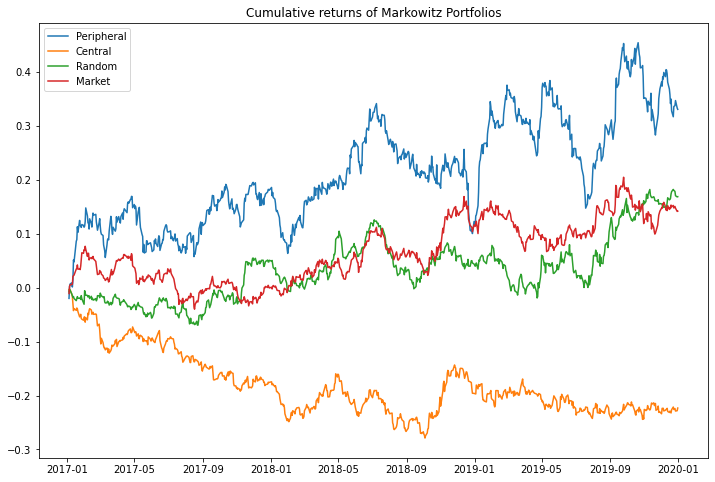

In [18]:
plt.figure(figsize=(12,8))
plt.title('Cumulative returns of Markowitz Portfolios')
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
#plt.plot(back_results.cumsum(), label=portfolio_names)
for name in portfolio_names:
    plt.plot(back_results[name].cumsum(), label=name)

plt.legend()
plt.show();

### Equal Weights

In [16]:
eqw_back_results = t_back.backtest_equal_weight(log_returns_df, SnP_returns, verbose=True)
eqw_back_results.head()

Initial peripheral basket:
 Index(['LNC', 'MTD', 'SNPS', 'MA', 'PKI', 'BAC', 'PRU', 'JPM', 'MS', 'IVZ',
       'PH', 'ITW', 'TMO', 'ETN', 'IEX', 'TEL', 'C', 'USD', 'APH', 'BLK',
       'ENPH', 'TAP', 'PAR', 'PIR', 'ITI', 'CMT', 'TCX', 'MLSS', 'LEE', 'CMG'],
      dtype='object')
Initial Central basket:
 Index(['KR', 'MNST', 'COG', 'SYY', 'NRG', 'FE', 'TSN', 'CAG', 'WMB', 'WLTW',
       'BH', 'RE', 'SRE', 'HSY', 'CHD', 'PRGO', 'D', 'BBY', 'NEE', 'EIX',
       'EXC', 'ULTA', 'WBA', 'WMT', 'UA', 'LB', 'VZ', 'NEM', 'CHRW', 'XOM'],
      dtype='object')

--------------------------
Recomputing filtered network at  2017-01-03 00:00:00

Stocks that left the peripheral basket: (0)
set()
Stocks that entered the peripheral basket:
set()

Stocks that entered the central basket: (0)
set()
Stocks that left the central basket: 
set()

--------------------------
Recomputing filtered network at  2017-04-04 00:00:00

Stocks that left the peripheral basket: (6)
{'PKI', 'SNPS', 'CMG', 'MTD', 'LNC', 'MA'}


,Peripheral,Central,Random,Market
2017-01-04,-0.002245,-0.004667,0.002276,-0.000775
2017-01-05,0.009655,0.001756,0.004907,0.005327
2017-01-06,-0.003662,-0.000155,-0.001404,-0.001975
2017-01-09,0.002026,-0.003037,-0.003995,-0.000115
2017-01-10,-0.004810,-0.004367,0.001925,-0.000872


In [21]:
print('Mean excess returns')
print(eqw_back_results.mean()*252)
print('\nTracking error:')
print(eqw_back_results.std() * np.sqrt(252))
print('\nInformation Ratio:')
print(eqw_back_results.mean()/eqw_back_results.std() * np.sqrt(252))

Mean excess returns
Peripheral    0.086731
Central      -0.021364
Random        0.051805
Market        0.035516
dtype: float64

Tracking error:
Peripheral    0.086054
Central       0.081328
Random        0.045790
Market        0.027838
dtype: float64

Information Ratio:
Peripheral    1.007866
Central      -0.262687
Random        1.131358
Market        1.275800
dtype: float64


In [24]:
eqw_betas = compute_betas(eqw_back_results)
eqw_betas

{'Peripheral': 1.0332876728916225,
 'Central': 1.0512512522717015,
 'Random': 0.9845995599082225,
 'Market': 1.0156842239305894}

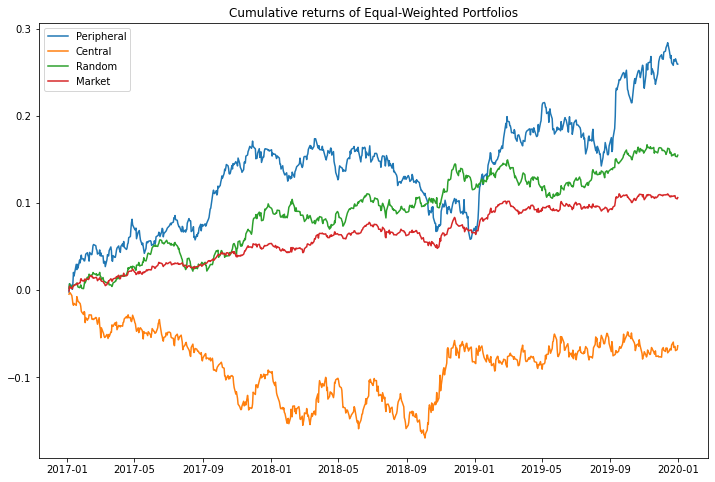

In [27]:
plt.figure(figsize=(12,8))
plt.title('Cumulative returns of Equal-Weighted Portfolios')
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
#plt.plot(back_results.cumsum(), label=portfolio_names)
for name in portfolio_names:
    plt.plot(eqw_back_results[name].cumsum(), label=name)

plt.legend()
plt.show();

### Smaller Basket Size

Initial peripheral basket:
 Index(['LNC', 'MTD', 'SNPS', 'MA', 'PKI', 'BAC', 'PRU', 'JPM', 'MS', 'IVZ',
       'PH', 'ITW', 'TMO', 'ETN', 'IEX', 'TEL', 'C', 'USD', 'APH', 'BLK',
       'ENPH', 'TAP', 'PAR', 'PIR', 'ITI', 'CMT', 'TCX', 'MLSS', 'LEE', 'CMG'],
      dtype='object')
Initial Central basket:
 Index(['KR', 'MNST', 'COG', 'SYY', 'NRG', 'FE', 'TSN', 'CAG', 'WMB', 'WLTW',
       'BH', 'RE', 'SRE', 'HSY', 'CHD', 'PRGO', 'D', 'BBY', 'NEE', 'EIX',
       'EXC', 'ULTA', 'WBA', 'WMT', 'UA', 'LB', 'VZ', 'NEM', 'CHRW', 'XOM'],
      dtype='object')

--------------------------
Recomputing filtered network at  2017-01-03 00:00:00

Stocks that left the peripheral basket: (0)
set()
Stocks that entered the peripheral basket:
set()

Stocks that entered the central basket: (0)
set()
Stocks that left the central basket: 
set()

--------------------------
Recomputing filtered network at  2017-04-04 00:00:00

Stocks that left the peripheral basket: (6)
{'PKI', 'SNPS', 'CMG', 'MTD', 'LNC', 'MA'}


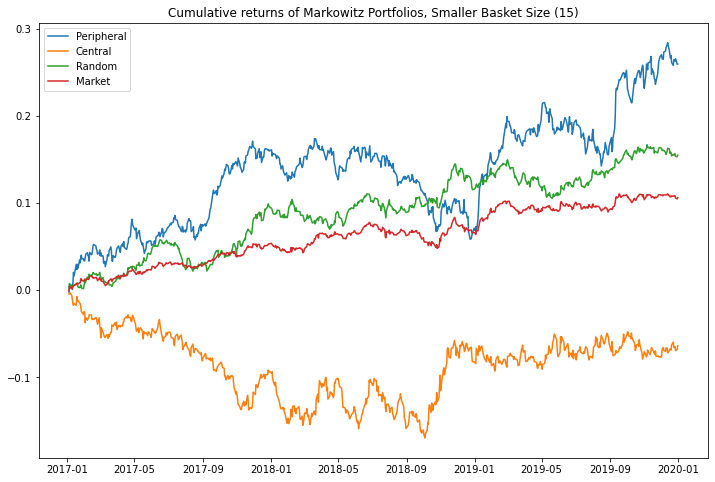

In [28]:
basket_size = 15

t_15 = Backtester(basket_size, 63, 1, 252, XY_rankings)
back_results = t_back.backtest_markowitz_weight(log_returns_df, SnP_returns, verbose=True)
print('\n---------------------------------\n')
print('Mean excess returns')
print(back_results.mean()*252)
print('\nTracking error:')
print(back_results.std() * np.sqrt(252))
print('\nInformation Ratio:')
print(back_results.mean()/eqw_back_results.std() * np.sqrt(252))
print('\nBetas:')
print(compute_betas(back_results))

plt.figure(figsize=(12,8))
plt.title('Cumulative returns of Markowitz Portfolios, Smaller Basket Size (%d)'%basket_size)
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
#plt.plot(back_results.cumsum(), label=portfolio_names)
for name in portfolio_names:
    plt.plot(eqw_back_results[name].cumsum(), label=name)

plt.legend()
plt.show();